<a href="https://colab.research.google.com/github/diegovelilla/CNNs-from-scratch/blob/main/CNNs_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CNN to predict on the MNIST dataset

In [19]:
from torchvision import datasets
import torchvision.transforms as transforms
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transforms.ToTensor())

In [20]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [21]:
test_data.data.size()

torch.Size([10000, 28, 28])

In [22]:
from torch.utils.data import DataLoader

loaders = {
    'train': DataLoader(train_data, batch_size=100, shuffle=True),
    'test': DataLoader(test_data, batch_size=100, shuffle=True)
}

In [30]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride=1)
    self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=1)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    # Input is 1x28x28 since it only has 1 color channel and the size is 28x28
    # Formula to calculate tensor size is:
    # (Input_size - Kernel_size)/Stride + 1
    # First convolutional layer
    x = self.conv1(x) # 10x24x24
    x = F.max_pool2d(x, kernel_size=2, stride=2) # 10x12x12
    x = F.relu(x) # 10x12x12

    # Second convolutional layer
    # Input is 10x12x12
    x = self.conv2(x) # 20x8x8
    x = self.conv2_drop(x) # 20x8x8
    x = F.max_pool2d(x, kernel_size=2, stride=2) # 20x4x4
    x = F.relu(x) # 20x4x4

    # First fully connected layer
    x = x.view(-1, 320) # Flattens 20x4x4 -> 320
    x = self.fc1(x) # 320 -> 50
    x = F.relu(x) # 50
    # x = F.dropout(x, training=self.training) # 50

    # Second fully connected layer
    x = self.fc2(x) # 50 -> 10
    x = F.softmax(x) # 10
    return x

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [25]:
model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [26]:
def train(model, loaders,  device, optimizer, loss_func):
  model.train()
  loss_vec = []
  for batch_idx, (data, target) in enumerate(loaders['train']):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = loss_func(output, target)
    loss_vec.append(loss.item())
    loss.backward()
    optimizer.step()

    if batch_idx % 100 == 0:
      print(f'Batch: {batch_idx}/{len(loaders["train"])}, Loss: {loss.item()}')
  return sum(loss_vec)/len(loss_vec)

def test(model, loaders, device, loss_vec, loss_func, acc_vec):
    model.eval()
    correct = 0
    test_loss = 0
    num_batches = len(loaders['test'])

    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_func(output, target)
            test_loss += loss.item()
            pred = output.argmax(1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    avg_test_loss = test_loss / num_batches
    accuracy = 100. * correct / len(loaders['test'].dataset)
    loss_vec.append(avg_test_loss)
    acc_vec.append(accuracy)
    print(f'Test loss: {avg_test_loss:.6f}, Accuracy: {accuracy:.2f}%')
    return loss_vec, acc_vec


In [ ]:
loss_vec = []
train_loss_vec = []
acc_vec = []
for epoch in range(20):
  train_loss_vec.append(train(model, loaders, device, optimizer, loss_func))
  print('-----------------------------------------------')
  print(f'For epoch number {epoch+1} the results are:')
  print(f'Train loss: {train_loss_vec[epoch]}')
  test_loss_vec, acc_vec = test(model, loaders, device, loss_vec, loss_func, acc_vec)
  print('-----------------------------------------------')

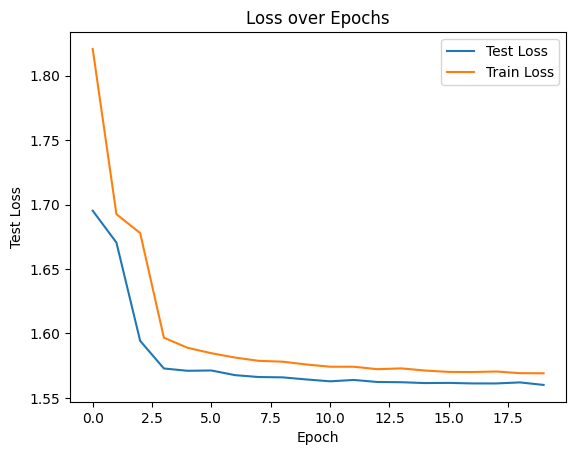

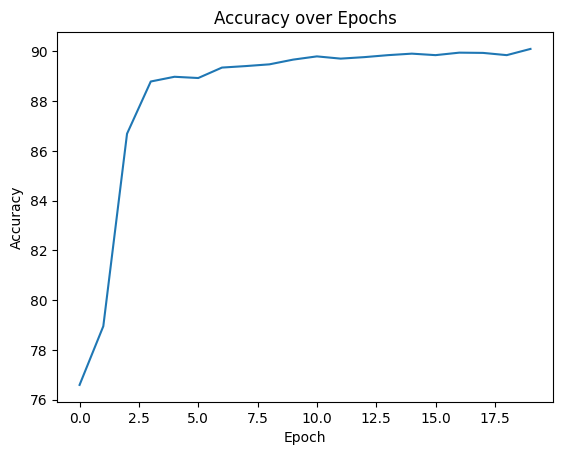

In [29]:
import matplotlib.pyplot as plt

# Assuming loss_vec is a list containing the loss values from each epoch
plt.plot(test_loss_vec)
plt.plot(train_loss_vec)
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Loss over Epochs')
plt.legend(['Test Loss', 'Train Loss'])
plt.show()

# plot also the accuracy
plt.plot(acc_vec)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.show()